In [19]:
%load_ext autoreload
%autoreload 2

from deep_bf.data_handler import DataLoader
import torch

dl = DataLoader("../../../rf_data")
pw = dl.get_defined_pwdata("contrast_speckle_expe_dataset_rf", "RF")
#pw = dl.get_defined_pwdata("contrast_speckle_simu_dataset_rf", "RF")

nz = 1024
nx = 512
#nz = 2048
#nx = 256

decimation = 1

fs = pw.fs
fc = pw.fc
rf = pw.data

def get_size(tensor):
    bytes = tensor.nelement() * tensor.element_size()
    print(f"La variable ocupa: {bytes / (1024 ** 2):.2f} MB")
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from deep_bf.beamformers import compute_d_rx, compute_d_tx, compute_meshgrid
import numpy as np

Z, X = compute_meshgrid(pw, nz, nx)
d_rx = compute_d_rx(pw, Z, X)

angles = np.arange(pw.n_angles)

d_tx, t0 = compute_d_tx(pw, Z, X, angle_indices=angles) # [n_angles, nz, nx]

In [21]:
from deep_bf.beamformers import GridSampleDAS

import torch
from torch.profiler import profile, record_function, ProfilerActivity

# Definir el contexto del profiler
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    profile_memory=True,  # Crucial para ver el historial de VRAM
    record_shapes=True
) as prof:
    with record_function("bloque_de_interes"):
        
        angle_batch_size = 8
        bf = GridSampleDAS(nz, nx, pw.c0, pw.fs, decimation=decimation, angle_batch_size=angle_batch_size).cuda()

        rf_tensor = torch.from_numpy(rf[angles]).half().cuda()
        #rf_tensor = torch.from_numpy(rf[angles]).cuda()

        with torch.no_grad():
            das_all_angles = bf(rf_tensor, d_tx, d_rx, t0)  # [n_angles, nz, nx]

# Exportar para ver en el navegador (Chrome Trace Viewer)
prof.export_chrome_trace("trace_memoria.json")

In [22]:
import numpy as np
from scipy.signal import hilbert

das_np = das_all_angles.cpu().numpy()
env = das_np.mean(axis=0)

env = np.abs(hilbert(env, axis=0))
env = 20 * np.log10(env + 1e-10)

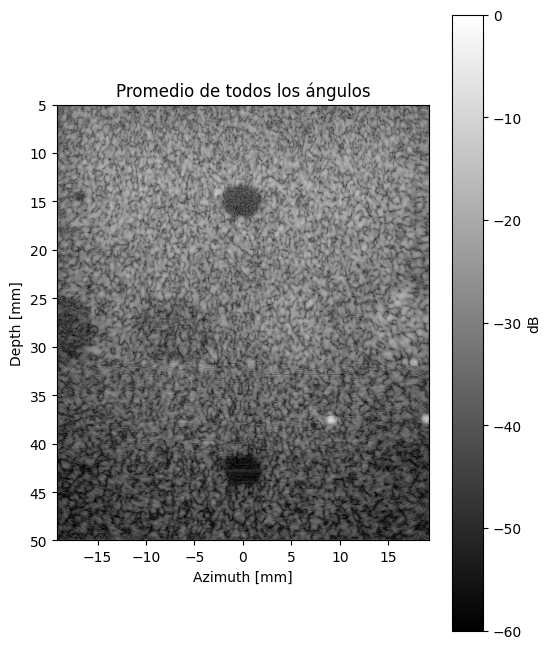

In [24]:
import matplotlib.pyplot as plt

Z1 = Z.cpu()
X1 = X.cpu()

zlims = np.array([Z1[0, 0], Z1[-1, 0]]) * 1e3
xlims = np.array([X1[0, 0], X1[0, -1]]) * 1e3

plt.figure(figsize=(6, 8))
plt.imshow(env, cmap='gray',vmin=-60, vmax=0,
           extent=(xlims[0], xlims[-1], zlims[-1], zlims[0]))
plt.title("Promedio de todos los ángulos")
plt.xlabel("Azimuth [mm]")
plt.ylabel("Depth [mm]")
plt.colorbar(label="dB")
plt.show()